In [69]:
import sys
import os
sys.path.insert(0,os.path.abspath("../lib/"))

import json

from util import JSONExtendedEncoder

from modulecontainers import Modules

%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd
import numpy as np

import multiprocessing as mp

from collections import OrderedDict

from itertools import product
from collections import defaultdict

import itertools
import shutil
import os

conf_folder = "conf/"
import os

from modulescomparison import ModevalKnownmodules, ModevalCoverage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Running a method

In [70]:
# datasets to run
originaldatasetnames = ["ecoli_colombos", "ecoli_dream5", "yeast_gpl2529", "yeast_dream5", "synth_ecoli_regulondb", "synth_yeast_macisaac", "human_tcga", "human_gtex", "human_seek_gpl5175"]
percs = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
datasetnames = [originaldatasetname + "/sample/{perc}".format(perc = "%03.0f" % (perc*100)) for originaldatasetname, perc in product(originaldatasetnames, percs)]

# paramexplo_blueprints.py stores for every method the parameters which will be varied using a grid-search approach.
%run ../conf/paramexplo_blueprints.py

# choose the method to evaluate
method_name = "agglom"
methodblueprint = blueprints[method_name]

In [71]:
params_folder = "conf/paramexplo/" + method_name + "/"
methodsettings = [json.load(open("../" + params_folder + file)) for file in os.listdir("../" + params_folder)]

In [72]:
settings_name = "subsample/{method_name}".format(method_name = method_name)
settings = []
for datasetname in datasetnames:
    for setting_ix, methodsetting in enumerate(methodsettings):
        settingid = datasetname + "_" + str(setting_ix)
        settings.append({
            "dataset_location":"conf/datasets/" + datasetname + ".json",
            "dataset_name":datasetname,
            "method_location":methodsetting["location"],
            "output_folder":"results/" + methodblueprint["type"] + "/{settings_name}/{settingid}/".format(settings_name=settings_name, settingid=settingid),
            "settingid":settingid
        })
file = "../conf/settings/{settings_name}.json".format(settings_name=settings_name)
os.makedirs(os.path.dirname(file), exist_ok = True)
json.dump(settings, open(file, "w"))

In [73]:
settings_dataset = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["dataset_location"]))["params"]) for setting in settings])
settings_method = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["method_location"]))["params"]) for setting in settings])

In [74]:
commands = ""
for i, setting in enumerate(settings):
    #commands += "python scripts/moduledetection.py {method_location} {dataset_location} {output_folder} 0 test\n".format(**setting)
    commands += "python3 scripts/" + methodblueprint["type"] + ".py {method_location} {dataset_location} {output_folder}\n".format(**setting)

commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs("../" + os.path.dirname(commands_location), exist_ok=True)
with open("../" + commands_location, "w") as outfile:
    outfile.write(commands)
commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs(os.path.dirname("../tmp/" + commands_location), exist_ok=True)
with open("../tmp/" + commands_location, "w") as outfile:
    outfile.write(commands)
    
#script_location = generate_batchcode(commands_location, settings_name, len(settings), {"memory":"10G", "numcores":1}, "biclust_comp2")

# this command can be used on most linux computers to run the different parameter settings in parallel
print("parallel -j 4 -a " + commands_location)

parallel -j 4 -a tmp/subsample/agglom.txt


# Evaluating the method

In [ ]:
# create pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(mp.cpu_count()-1)

In [76]:
settings_filtered = [setting for setting in settings if not setting["dataset_name"].startswith("human")] # only evaluate non-human datasets
modeval = ModevalKnownmodules(settings_filtered, baseline = True)
modeval.run(pool)

In [77]:
modeval.save(settings_name)

In [78]:
settings_filtered = [setting for setting in settings if setting["dataset_name"].startswith("human")]
modeval = ModevalCoverage(settings_filtered, baseline = True)
modeval.run(pool)

Evaluating a total of 504 settings.


In [79]:
modeval.save(settings_name)

## Comparing methods

In [86]:
def score_method(scores):
    methodscores = []
    for ((datasetoi, goldstandardoi), scoresoi), ((datasetor, goldstandardor), scoresor) in product(scores.groupby(["datasetname", "goldstandard"]), scores.groupby(["datasetname", "goldstandard"])):
        if (datasetor.split("_")[0]=="synth" and datasetoi.split("_")[0]!="synth") or (datasetor.split("_")[0]!="synth" and datasetoi.split("_")[0]=="synth"):
            continue
                
        if (goldstandardoi.split("#")[-1] != goldstandardor.split("#")[-1]):
            if (datasetoi.startswith("human") != datasetor.startswith("human")):
                ""
            else:
                continue

        # find the most optimal method parameters in the reference dataset (test dataset)
        bestparams = scoresor[paramsoi].loc[scoresor["score"].idxmax()]
        
        try:
            rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
        except:
            print(scoresoi)

        # now find these parameters in the dataset of interest (training dataset)
        rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
            
        if len(rowids) == 0:
            print("parameters could not be matched!!", datasetoi, datasetor)
            print(bestparams)
            print([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()])
        if len(rowids) > 1:
            print(datasetoi)
            print("multiple matched parameters")
            print(scoresoi.ix[rowids][paramsoi])

        methodscores.append({
            "datasetoi":datasetoi,
            "datasetor":datasetor,
            "score":scoresoi.loc[rowids,"score"].max(),
            "method":methodname,
            "goldstandardoi":goldstandardoi,
            "goldstandardor":goldstandardor,
            "ofinterest":datasetoi + "#" + goldstandardoi,
            "ofreference":datasetor + "#" + goldstandardor,
            "runningtime":scoresoi.loc[rowids, "runningtime"].mean() if "runningtime" in scoresoi.columns else 0,
            "moduledef":scoresoi.loc[rowids, "moduledef"].tolist()[0],
            "organismoi":scoresoi.loc[rowids, "organism"].tolist()[0],  
        })
    
    return pd.DataFrame(methodscores)

In [87]:
methodnames = ["dummy", "agglom"]

In [88]:
finalscores = []
for methodname in methodnames:
    settings_name = "subsample/" + methodname
    settings = json.load(open("../conf/settings/{}.json".format(settings_name)))
    settings_dataset = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["dataset_location"]))["params"]) for setting in settings])
    settings_method = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["method_location"]))["params"]) for setting in settings])
    
    print(methodname)
    paramsoi = methodparamsoi[methodname]

    scores = pd.DataFrame()
    
    modeval = ModevalKnownmodules(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["F1rprr_permuted"]
    modeval.scores["moduledef"] = [modulesname if modulesname in ["minimal", "strict"] else "interconnected" for modulesname in modeval.scores["knownmodules_name"]]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    modeval = ModevalCoverage(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["aucodds_permuted"]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    for perc, settingids in settings_dataset.groupby("perc")["settingid"]:
        methodscores = score_method(scores.loc[scores["settingid"].isin(settingids)])
        
        methodscores["perc"] = perc
    
        methodscores["organismnetoi"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardoi"]]
        methodscores["organismnetor"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardor"]]

        finalscores.append(methodscores)
finalscores = pd.concat(finalscores, ignore_index=True)

dummy
agglom


In [89]:
def add_weights(scores):
    weights = []
    scores["moduledef"] = scores["moduledef"].fillna("")
    for organismoi, subscores in scores.groupby("organismoi"):
        moduledef_weights = 1/subscores.groupby("moduledef")["score"].count()
        for moduledef, weight in moduledef_weights.items():
            weights.append({
                    "organism":organismoi,
                    "moduledef":moduledef,
                    "weight":weight / len(moduledef_weights)
                })
    weights = pd.DataFrame(weights).set_index(["organism", "moduledef"])["weight"]
    
    scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()
    
    return scores

In [ ]:
trainingscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] == finalscores["ofreference"])])
testscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] != finalscores["ofreference"]) & (finalscores["organismnetoi"] != finalscores["organismnetor"])])

trainingscores = trainingscores_.groupby(["perc", "method"]).apply(lambda x: np.average(x.score, weights=x.weight)).unstack()
testscores = testscores_.groupby(["perc", "method"]).apply(lambda x: np.average(x.score, weights=x.weight)).unstack()

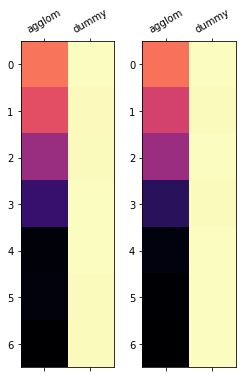

In [91]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(len(testscores.columns)*2, 6))

for ax, scores in zip([ax1, ax2], [testscores, trainingscores]):
    ax.matshow(scores, cmap=cm.magma_r)

    ax.set_xticks(np.arange(len(testscores.columns)))
    ax.set_xticklabels(testscores.columns, rotation=30)